In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_image(path, isGrayScale=False):
    if isGrayScale:
        return cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(path)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return rgb_image

def grayscaleToColor(img):
    res = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return res

In [3]:
def binary_thresholding(image, threshold):
    binary_image = np.where(image > threshold, 255, 0).astype(np.uint8)
    return binary_image

def adaptive_thresholding(image, block_size, C):
    adaptive_image = np.zeros_like(image)
    padded_image = cv2.copyMakeBorder(image, block_size // 2, block_size // 2, 
                                      block_size // 2, block_size // 2, cv2.BORDER_REFLECT)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            block = padded_image[i:i + block_size, j:j + block_size]
            local_threshold = np.mean(block) - C
            adaptive_image[i, j] = 255 if image[i, j] > local_threshold else 0
            
    return adaptive_image

def otsu_thresholding(image):
    pixel_counts, bin_edges = np.histogram(image, bins=256, range=(0, 256))
    total_pixels = image.size
    current_max_variance, threshold = 0, 0
    sum_total, sum_foreground, weight_foreground = np.sum(np.arange(256) * pixel_counts), 0, 0

    for t in range(256):
        weight_foreground += pixel_counts[t]
        if weight_foreground == 0:
            continue

        weight_background = total_pixels - weight_foreground
        if weight_background == 0:
            break

        sum_foreground += t * pixel_counts[t]
        mean_foreground = sum_foreground / weight_foreground
        mean_background = (sum_total - sum_foreground) / weight_background

        # Between class variance
        variance_between = weight_foreground * weight_background * (mean_foreground - mean_background) ** 2

        if variance_between > current_max_variance:
            current_max_variance = variance_between
            threshold = t

    otsu_image = np.where(image > threshold, 255, 0).astype(np.uint8)
    return otsu_image, threshold


In [4]:
parrot_img = read_image('../images/parrot.jpeg',isGrayScale=True)

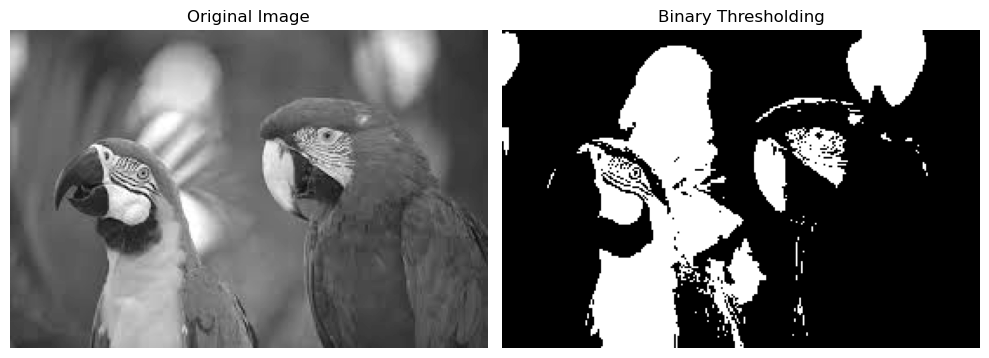

In [15]:
binary_thresholded = binary_thresholding(parrot_img, 128)
adaptive_thresh = adaptive_thresholding(parrot_img, block_size=15, C=10)
otsu_thresh, otsu_val = otsu_thresholding(parrot_img)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(parrot_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Binary Thresholding")
plt.imshow(binary_thresholded, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

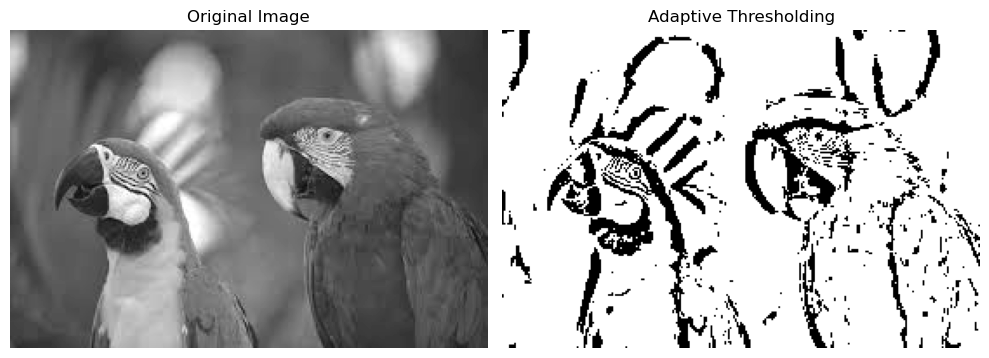

In [16]:
adaptive_thresholded = adaptive_thresholding(parrot_img, block_size=15, C=10)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(parrot_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Adaptive Thresholding")
plt.imshow(adaptive_thresholded, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

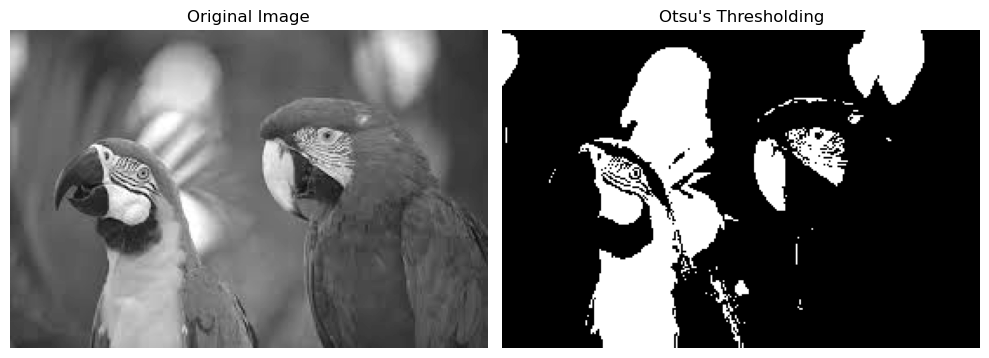

In [17]:
otsu_thresholded, otsu_val = otsu_thresholding(parrot_img)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(parrot_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Otsu's Thresholding")
plt.imshow(otsu_thresholded, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

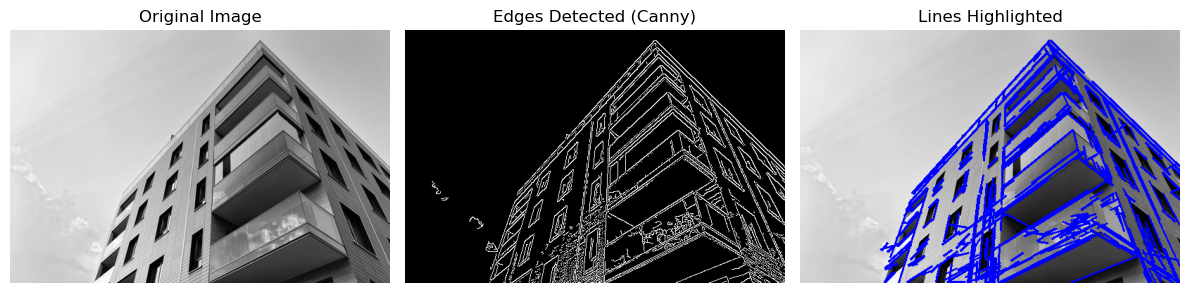

In [5]:
def detect_and_highlight_lines(image, canny_threshold1, canny_threshold2, hough_threshold, min_line_length, max_line_gap):
    """
    Detects and highlights straight lines in an image using the Hough Line Transform.

    Parameters:
    - image: Input grayscale image.
    - canny_threshold1, canny_threshold2: Thresholds for the Canny edge detector.
    - hough_threshold: Minimum number of votes for a line to be considered.
    - min_line_length: Minimum line length in pixels for Hough Transform.
    - max_line_gap: Maximum gap between line segments to treat as a single line.

    Returns:
    - result: Image with detected lines highlighted.
    """
    # Apply Canny edge detector
    edges = cv2.Canny(image, canny_threshold1, canny_threshold2)
    
    # Detect lines using the Hough Line Transform
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=hough_threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    # Create a copy of the original image to draw lines
    result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Draw the detected lines on the result image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(result, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Blue lines
    
    return edges, result

# Generate a synthetic image for testing
# np.random.seed(42)
# test_image = np.zeros((256, 256), dtype=np.uint8)
# cv2.line(test_image, (50, 50), (200, 50), 255, 2)  # Horizontal line
# cv2.line(test_image, (50, 50), (50, 200), 255, 2)  # Vertical line
road_img = read_image('../images/building.jpg', True)
# Apply the function
edges, highlighted_image = detect_and_highlight_lines(road_img, 50, 150, 50, 10, 5)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(road_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Edges Detected (Canny)")
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Lines Highlighted")
plt.imshow(highlighted_image)
plt.axis('off')

plt.tight_layout()
plt.show()


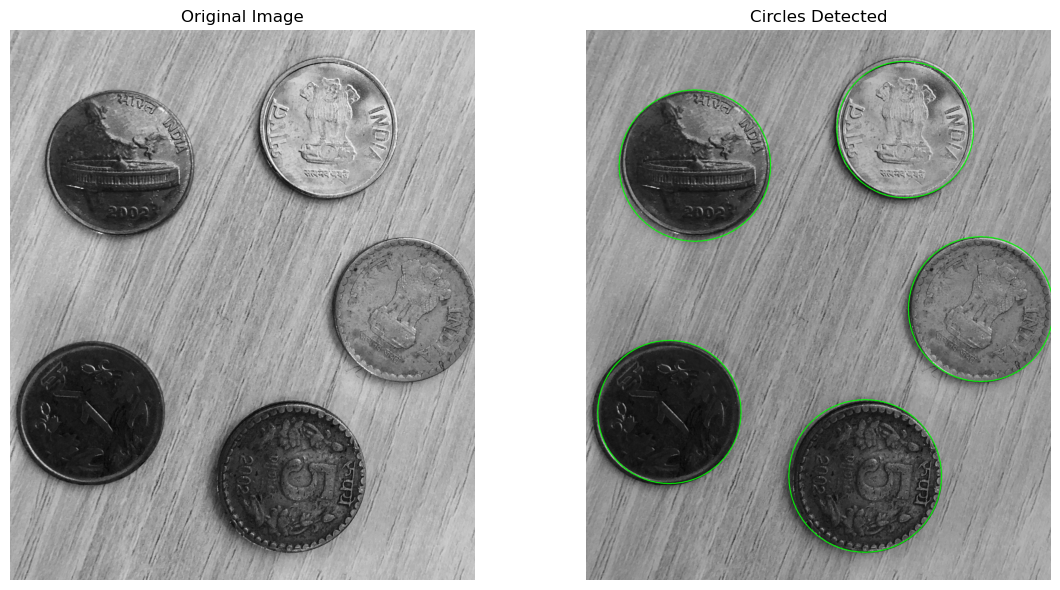

In [ ]:
def detect_circles(image, dp, min_dist, param1, param2, min_radius, max_radius):
    """
    Detects circles in an image using the Hough Circle Transform.

    Parameters:
    - image: Input grayscale image.
    - dp: Inverse ratio of the accumulator resolution to the image resolution.
    - min_dist: Minimum distance between the centers of detected circles.
    - param1: Higher threshold for Canny edge detection (lower threshold is set to half).
    - param2: Threshold for the accumulator in the Hough Circle Transform.
    - min_radius: Minimum radius of circles to detect.
    - max_radius: Maximum radius of circles to detect.

    Returns:
    - result: Image with detected circles highlighted.
    - circles: Detected circles (x, y, radius).
    """
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(image, (9, 9), 1)

    # Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp=dp, minDist=min_dist,
                               param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)

    # Create a copy of the original image to draw circles
    result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))  # Round the values to integers
        for circle in circles[0, :]:
            x, y, radius = circle
            cv2.circle(result, (x, y), radius, (0, 255, 0), 4)  # Draw the circle in green
            # cv2.circle(result, (x, y), 2, (0, 0, 255), 3)  # Draw the center in red
    
    return result, circles

# coin_img = read_image('../images/coin.jpg', True)
coin_img = read_image('../images/coin-detection.jpg', True)

# Apply the function
highlighted_image, detected_circles = detect_circles(coin_img, dp=1.2, min_dist=800,
                                                     param1=90, param2=50,
                                                     min_radius=300, max_radius=400)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(coin_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Circles Detected")
plt.imshow(highlighted_image)
plt.axis('off')

plt.tight_layout()
plt.show()

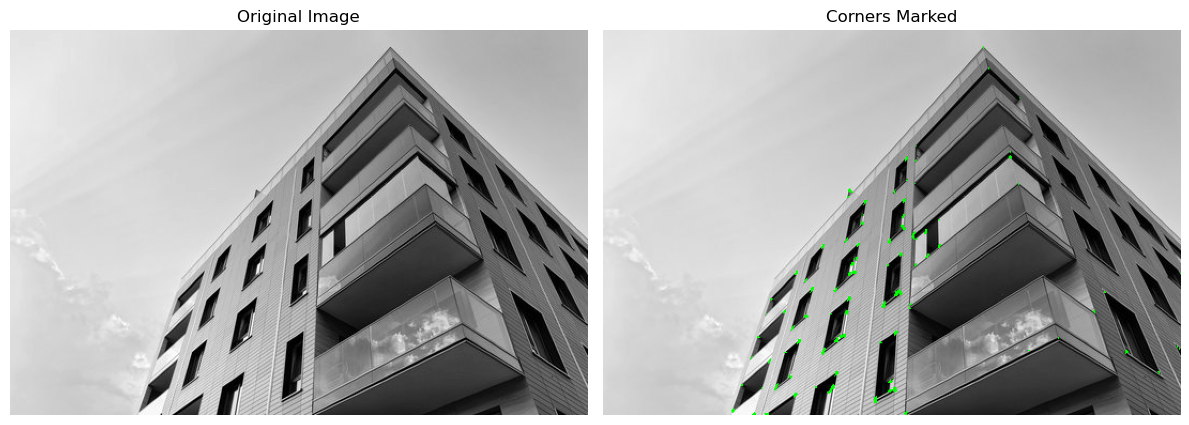

In [55]:
def detect_and_mark_corners(image, block_size, ksize, k, threshold):
    """
    Detects and marks corners in an image using the Harris Corner Detection method.

    Parameters:
    - image: Input grayscale image.
    - block_size: Neighborhood size (e.g., 2x2, 3x3) for corner detection.
    - ksize: Aperture parameter for the Sobel derivative (should be odd).
    - k: Harris detector free parameter (usually between 0.04 and 0.06).
    - threshold: Threshold to mark strong corners.

    Returns:
    - result: Image with detected corners marked.
    - corners: Detected corner response map.
    """
    # Detect corners using the Harris Corner Detection method
    corners = cv2.cornerHarris(image, block_size, ksize, k)
    
    # Normalize the corner response
    corners_normalized = cv2.normalize(corners, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    # Create a copy of the original image to mark corners
    result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Mark corners where the response is above the threshold
    result[corners_normalized > threshold] = [0, 255, 0]  # Mark corners in red
    
    return result, corners_normalized



road_img = read_image('../images/building.jpg',True)
# Apply the function
marked_image, corners_response = detect_and_mark_corners(road_img, block_size=3, ksize=3, k=0.04, threshold=80)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(road_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Corners Marked")
plt.imshow(marked_image)
plt.axis('off')

plt.tight_layout()
plt.show()
